In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp  # Import TensorFlow Probability
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### standard sci-py libraries

import matplotlib.pyplot as plt
import pandas as pd
import uproot ### to read, convert, inspect ROOT TTrees

from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

2023-08-08 11:12:59.661354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

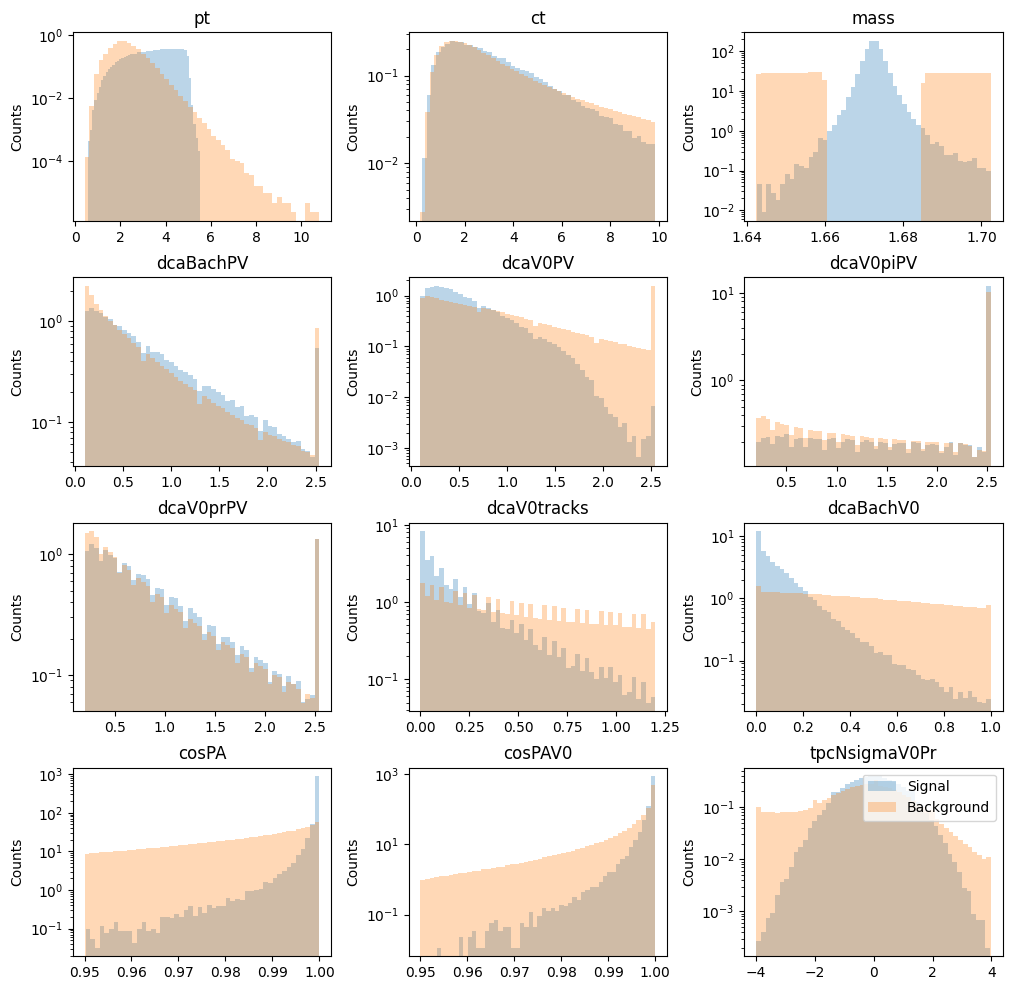

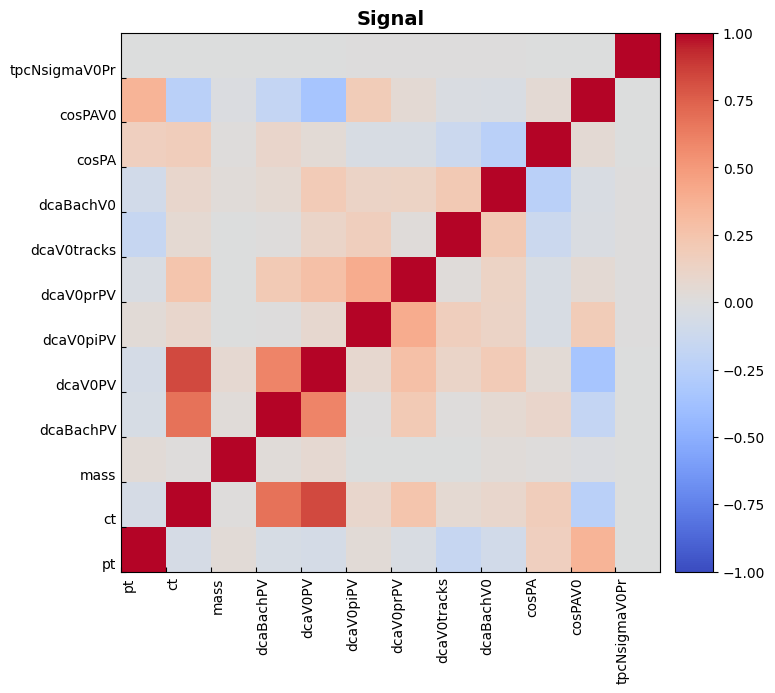

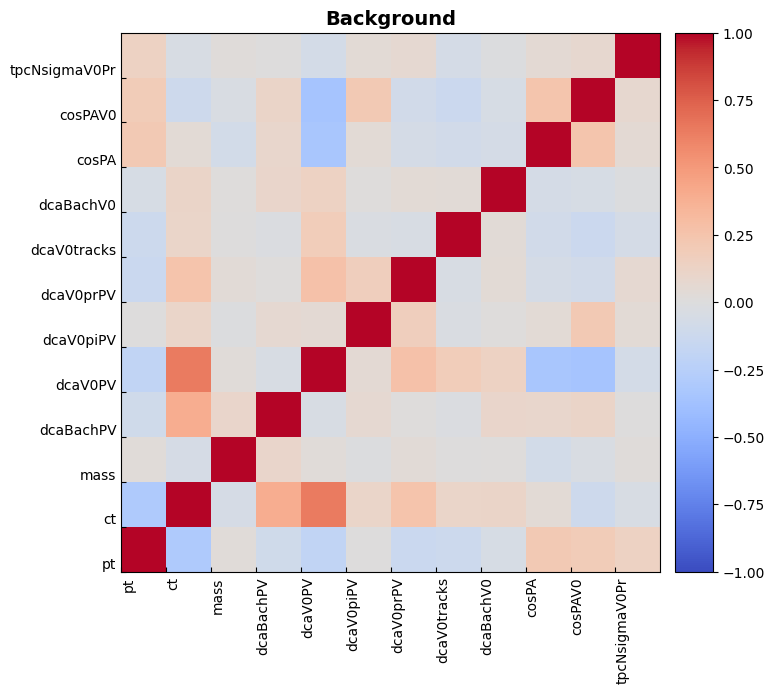

In [2]:
hdl_mc = TreeHandler("AnalysisResults-mc_reduced.root", "XiOmegaTree")
hdl_data = TreeHandler("AnalysisResults_reduced.root", "XiOmegaTree")


hdl_mc.apply_preselections("abs(pdg)==3334 and isOmega==1 and isReconstructed==1") 

hdl_bkg = hdl_data.apply_preselections("mass < 1.660 or mass > 1.685", inplace=False)

hdl_data.apply_preselections("mass > 1.660 and mass < 1.685", inplace=True)

cols_to_be_compared = ['pt', 'ct', 'mass', 'dcaBachPV', 'dcaV0PV', 'dcaV0piPV', 'dcaV0prPV', 'dcaV0tracks', 
                 'dcaBachV0','cosPA', 'cosPAV0', 'tpcNsigmaV0Pr']

## some matplotlib tuning is needed to display all the features
plot_utils.plot_distr([hdl_mc, hdl_bkg], cols_to_be_compared, 
                      bins=50, labels=['Signal', 'Background'],
                      log=True, density=True, figsize=(12, 12), alpha=0.3, grid=False);

plot_utils.plot_corr([hdl_mc, hdl_bkg], cols_to_be_compared, labels=['Signal', 'Background']);

train_test_data = analysis_utils.train_test_generator([hdl_bkg, hdl_mc], [0, 1], test_size=0.5, random_state=42)



In [7]:
x_train=train_test_data[0]
y_train=train_test_data[1]

x_test=train_test_data[2]
y_test=train_test_data[3]

# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [8]:
x_train.columns

Index(['V0invMassDelta', 'bachBarCosPA', 'centrality', 'competingMass',
       'cosPA', 'cosPAV0', 'ct', 'ctMC', 'dcaBachPV', 'dcaBachV0', 'dcaV0PV',
       'dcaV0piPV', 'dcaV0prPV', 'dcaV0tracks', 'eta', 'etaMC', 'flag',
       'hasITSrefit', 'hasTOFhit', 'index', 'isOmega', 'isReconstructed',
       'mass', 'matter', 'pdg', 'pt', 'ptMC', 'radius', 'radiusV0',
       'tpcClBach', 'tpcClV0Pi', 'tpcClV0Pr', 'tpcNsigmaBach', 'tpcNsigmaV0Pi',
       'tpcNsigmaV0Pr', 'yMC'],
      dtype='object')

In [9]:
# Define a Bayesian Neural Network model using TensorFlow Probability
def build_bnn_model():
    model = tf.keras.Sequential([
        tfp.layers.DenseFlipout(80, activation='relu'),
        tfp.layers.DenseFlipout(80, activation='relu'),
#         tfp.layers.DenseFlipout(80, activation='relu'),
#         tfp.layers.DenseFlipout(80, activation='relu'),
        tfp.layers.DenseFlipout(1, activation='sigmoid')
    ])
    return model


In [10]:

# Create a custom scikit-learn estimator using TensorFlow and TFP
from sklearn.base import BaseEstimator, ClassifierMixin

class BayesianNeuralNetwork(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=100, batch_size=32, learning_rate=0.02):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = build_bnn_model()
    
    def fit(self, X, y):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        
        self.model.compile(loss=self.negative_log_likelihood, optimizer='adam')
        self.model.fit(X, y, epochs=self.n_epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y_pred = self.model(X).numpy()
        return (y_pred > 0.5).astype(int)
    
    def negative_log_likelihood(self, y_true, y_pred):
        return -tf.reduce_mean(self.log_likelihood(y_true, y_pred))
    
    def log_likelihood(self, y_true, y_pred):
        return tf.reduce_sum(
            tfp.distributions.Bernoulli(logits=y_pred).log_prob(y_true)
        )


In [11]:
n_epochs=32
batch_size=155
learning_rate=0.1
bnn = BayesianNeuralNetwork(n_epochs=n_epochs,batch_size=batch_size,learning_rate=learning_rate)

2023-08-08 11:13:52.513429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [12]:
bnn.fit(x_train, y_train)

`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
2023-08-08 11:13:59.226345: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


BayesianNeuralNetwork(batch_size=155, learning_rate=0.1, n_epochs=32)

In [ ]:
score_test = bnn.predict(train_test_data[2])

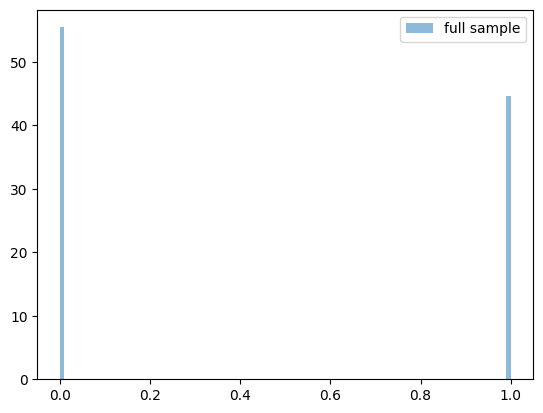

In [41]:
#### plot the score distribution
plt.hist(score_test, bins=100, label='full sample', alpha=0.5, density=True);
plt.legend();

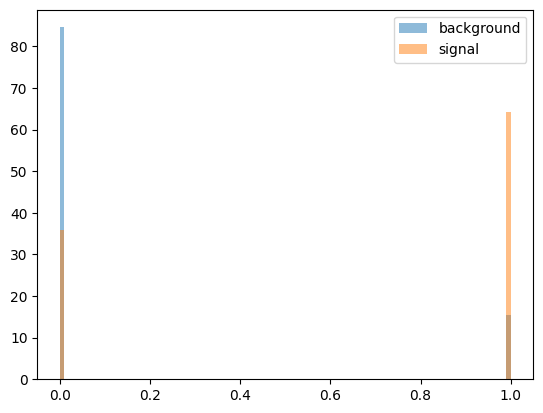

In [42]:
plt.hist(score_test[train_test_data[3]==0], bins=100, label='background', alpha=0.5, density=True);
plt.hist(score_test[train_test_data[3]==1], bins=100, label='signal', alpha=0.5, density=True);
plt.legend();


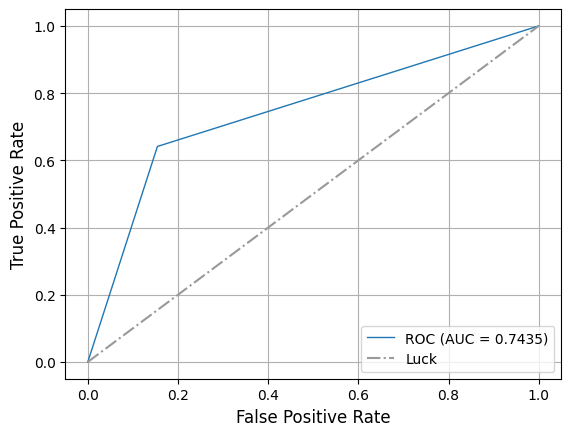

In [43]:
plot_utils.plot_roc(train_test_data[3], score_test);


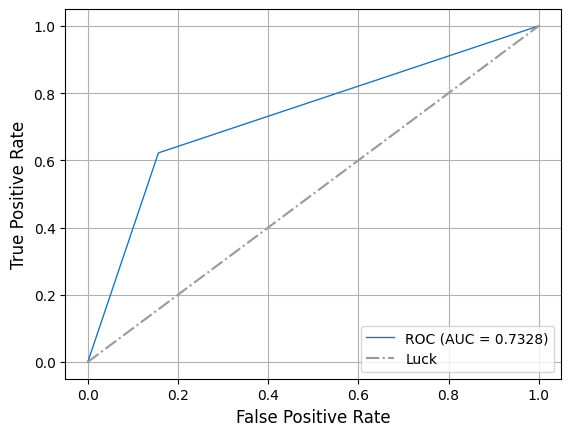

In [44]:
score_train = bnn.predict(train_test_data[0][training_cols])
plot_utils.plot_roc(train_test_data[1], score_train);

In [45]:
hdl_data_pandas=hdl_data.get_data_frame()
hdl_data_tf=tf.convert_to_tensor(hdl_data_pandas, dtype=tf.float32)
predictions=bnn.predict(hdl_data_pandas[training_cols])

full_predictions = bnn.predict(hdl_data_pandas[training_cols])

original_index = hdl_data_pandas.index


full_predictions_df = pd.DataFrame(full_predictions, columns=['Predictions'], index=original_index)


hdl_data_pandas['Predictions'] = full_predictions_df['Predictions']

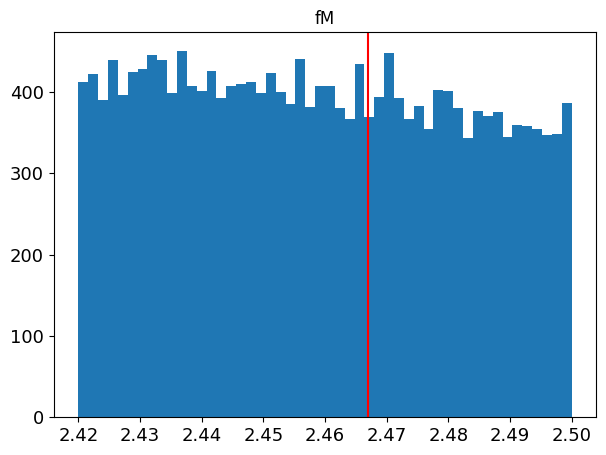

In [46]:
listOfCol=['fM']
cutString='Predictions==1'
hdl_data_pandas.query(cutString).hist(column=listOfCol,figsize=(7,5),xlabelsize=13,ylabelsize=13,grid=0,bins=50,log=0)
plt.axvline(2.467, 0, 1, label='pyplot vertical line',color='r')